In [1]:
#pip install tensorflow

In [2]:
#pip install keras

In [3]:
#pip install textblob

In [4]:
#pip install nbconvert[webpdf]

In [5]:
#pip uninstall emoji

In [6]:
#pip install emoji==1.7

In [7]:
#pip install emot

In [8]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras import callbacks
from dateutil.parser import parse
import textblob
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import re
from sklearn.model_selection import train_test_split
import emoji
from emoji import UNICODE_EMOJI
import emot

In [9]:
sns.set_palette("BrBG")

In [10]:
sns.set_style("whitegrid")

In [11]:
# Load datasets
def load_dataset(path):
    return pd.read_csv(path, names=['review', 'sentiments'], sep='\t')

amazon = load_dataset('amazon_cells_labelled.txt')
imdb = load_dataset('imdb_labelled.txt')
yelp = load_dataset('yelp_labelled.txt')

In [12]:
amazon['Source'] = 'amazon'
imdb['Source'] = 'imdb'
yelp['Source'] = 'yelp'

In [13]:
# Display datasets
def display_dataset(name, df):
    print(f"{name}: {df.head(15)}")

display_dataset('Amazon', amazon)
display_dataset('IMDB', imdb)
display_dataset('Yelp', yelp)

Amazon:                                                review  sentiments  Source
0   So there is no way for me to plug it in here i...           0  amazon
1                         Good case, Excellent value.           1  amazon
2                              Great for the jawbone.           1  amazon
3   Tied to charger for conversations lasting more...           0  amazon
4                                   The mic is great.           1  amazon
5   I have to jiggle the plug to get it to line up...           0  amazon
6   If you have several dozen or several hundred c...           0  amazon
7         If you are Razr owner...you must have this!           1  amazon
8                 Needless to say, I wasted my money.           0  amazon
9                    What a waste of money and time!.           0  amazon
10                    And the sound quality is great.           1  amazon
11  He was very impressed when going from the orig...           1  amazon
12  If the two were seperated 

In [14]:
# Review dataset sizes
def review_dataset_size(df, name):
    print(f"{name}: {df.shape}")

review_dataset_size(amazon, 'Amazon')
review_dataset_size(imdb, 'IMDB')
review_dataset_size(yelp, 'Yelp')

Amazon: (1000, 3)
IMDB: (748, 3)
Yelp: (1000, 3)


In [15]:
# Review individual DataFrame info and shapes
print("Amazon:")
amazon.info()
print("IMDB:", imdb.shape)
imdb.info()
print("Yelp:", yelp.shape)
yelp.info()

Amazon:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      1000 non-null   object
 1   sentiments  1000 non-null   int64 
 2   Source      1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB
IMDB: (748, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      748 non-null    object
 1   sentiments  748 non-null    int64 
 2   Source      748 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.7+ KB
Yelp: (1000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      1000 non-null   object
 1   sentiments  1000 non

In [16]:
#Get sentiment counts
def get_sentiment_counts(df, name):
    print(f"Sentiment counts for {name}:")
    if 'sentiments' in df.columns:
        sentiment_counts = df['sentiments'].value_counts()
        print(sentiment_counts)
    else:
        print("DataFrame does not contain a 'sentiments' column.")

# Get sentiment counts
get_sentiment_counts(amazon, 'Amazon')
get_sentiment_counts(imdb, 'IMDB')
get_sentiment_counts(yelp, 'Yelp')


Sentiment counts for Amazon:
sentiments
0    500
1    500
Name: count, dtype: int64
Sentiment counts for IMDB:
sentiments
1    386
0    362
Name: count, dtype: int64
Sentiment counts for Yelp:
sentiments
1    500
0    500
Name: count, dtype: int64


In [17]:
# Combine the three labeled review files
finaldf = pd.concat([amazon, yelp, imdb], ignore_index= True)
finaldf


,review,sentiments,Source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2743,I just got bored watching Jessice Lange take h...,0,imdb
2744,"Unfortunately, any virtue in this film's produ...",0,imdb
2745,"In a word, it is embarrassing.",0,imdb
2746,Exceptionally bad!,0,imdb


In [18]:
finaldf['Length'] = finaldf['review'].str.len()

# number of words
finaldf["Words"] = finaldf["review"].str.split().str.len()
finaldf.head()

,review,sentiments,Source,Length,Words
0,So there is no way for me to plug it in here i...,0,amazon,82,21
1,"Good case, Excellent value.",1,amazon,27,4
2,Great for the jawbone.,1,amazon,22,4
3,Tied to charger for conversations lasting more...,0,amazon,79,11
4,The mic is great.,1,amazon,17,4


In [19]:
print('Length min: ',finaldf.Length.min(),', max: ', finaldf.Length.max(),', avg: ', '{:.2f}'.format(finaldf.Length.mean()))
print('Words min: ',finaldf.Words.min(),', max: ', finaldf.Words.max(),', avg: ', '{:.2f}'.format(finaldf.Words.mean()))

Length min:  7 , max:  7944 , avg:  71.53
Words min:  1 , max:  1390 , avg:  13.01


In [20]:
# Check combined DataFrame
finaldf.info()

# Check for null values
null_counts = finaldf.isnull().sum()
print(null_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      2748 non-null   object
 1   sentiments  2748 non-null   int64 
 2   Source      2748 non-null   object
 3   Length      2748 non-null   int64 
 4   Words       2748 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 107.5+ KB
review        0
sentiments    0
Source        0
Length        0
Words         0
dtype: int64


In [21]:
# Check missing data and its size
def missing_cols(df):
    """Prints columns with their amount of missing values."""
    total = df.isnull().sum().sum()
    if total == 0:
        print("There are no missing values.")
    else:
        for col, missing_vals in df.isnull().sum().items():
            if missing_vals != 0:
                print(f"{col} => {missing_vals}")

missing_cols(finaldf)

# Check combined DataFrame info
print("Combined DataFrame Info:")
finaldf.info()

There are no missing values.
Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      2748 non-null   object
 1   sentiments  2748 non-null   int64 
 2   Source      2748 non-null   object
 3   Length      2748 non-null   int64 
 4   Words       2748 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 107.5+ KB


In [22]:
# Check combined DataFrame columns
print("Combined DataFrame Columns:")
print(finaldf.columns)

# Check combined DataFrame type
print("Combined DataFrame Type:")
print(type(finaldf))

# Check data types of features
print("Data Types of Features:")
print(finaldf.dtypes)

# Check binary rating (0 = negative, 1 = positive)
print("Binary Rating (0 = Negative, 1 = Positive):")
print(finaldf['sentiments'].unique())

Combined DataFrame Columns:
Index(['review', 'sentiments', 'Source', 'Length', 'Words'], dtype='object')
Combined DataFrame Type:
<class 'pandas.core.frame.DataFrame'>
Data Types of Features:
review        object
sentiments     int64
Source        object
Length         int64
Words          int64
dtype: object
Binary Rating (0 = Negative, 1 = Positive):
[0 1]


Sentiments Count:
sentiments
1    1386
0    1362
Name: count, dtype: int64
Sentiments Distribution (Count):
sentiments
1    0.504367
0    0.495633
Name: count, dtype: float64
Dataset Statistics:
        sentiments       Length       Words
count  2748.000000  2748.000000  2748.00000
mean      0.504367    71.528384    13.00655
std       0.500072   201.987266    35.81939
min       0.000000     7.000000     1.00000
25%       0.000000    32.000000     6.00000
50%       1.000000    55.000000    10.00000
75%       1.000000    87.000000    16.00000
max       1.000000  7944.000000  1390.00000


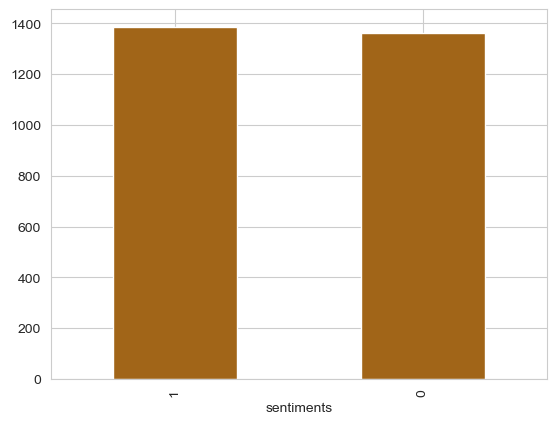

In [23]:
# Check positive and negative reviews from combined DataFrame
print("Sentiments Count:")
print(finaldf.sentiments.value_counts())

# Analyze distribution of the ratings (sentiments)
print("Sentiments Distribution (Count):")
print(finaldf.sentiments.value_counts() / len(finaldf))

# Plot sentiments distribution
finaldf['sentiments'].value_counts().plot(kind='bar')

# Describe dataset statistics
print("Dataset Statistics:")
print(finaldf.describe())

In [24]:
# Check for emoji :)
print("Lines containing :) emoji:")
for review in finaldf.review:
    if ":)" in review:
        print("The line contains :) emoji")

Lines containing :) emoji:
The line contains :) emoji
The line contains :) emoji
The line contains :) emoji
The line contains :) emoji


In [25]:

def checkEmoji(text):
    has_emoji = bool(emoji.get_emoji_regexp().search(text))
    return has_emoji
    
finaldf["emoji"] = finaldf['review'].apply(lambda x: checkEmoji(x))

finaldf['emoji'].value_counts()

emoji
False    2748
Name: count, dtype: int64

In [26]:
def check_emoticons(text):
    emot_obj = emot.core.emot()
    emote = emot_obj.emoticons(text)
    emote = emote.get('flag')
    return emote

finaldf["emote"] = finaldf["review"].apply(lambda x: check_emoticons(x))

In [27]:
#Reviews with emoticons
df_emote = finaldf[finaldf['emote']== True]
df_emote

,review,sentiments,Source,Length,Words,emoji,emote
76,Do Not Buy for D807...wrongly advertised for D...,0,amazon,50,8,False,True
387,The best phone in market :).,1,amazon,28,6,False,True
977,":-)Oh, the charger seems to work fine.",1,amazon,38,7,False,True
1207,The WORST EXPERIENCE EVER.,0,yelp,26,4,False,True
1613,"Sorry, I will not be getting food from here an...",0,yelp,59,12,False,True
1723,Special thanks to Dylan T. for the recommendat...,1,yelp,93,18,False,True
2179,I really loved the story line and the poler be...,1,imdb,129,24,False,True
2223,This movie is excellent!Angel is beautiful and...,1,imdb,381,62,False,True
2321,Final Word: This Show is a real torture!!,0,imdb,43,8,False,True
2734,;) Recommend with confidence!,1,imdb,31,4,False,True


In [28]:
#check for unusual characters
def isEnglish(review):
    return review.isascii()
for i in finaldf.review:
    if isEnglish(i) != True:
        print(isEnglish(i))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [29]:
reviews = finaldf['review']
char_set = set()

# Extract unique characters
for review in reviews:
    for word in word_tokenize(review.lower()):
        char_set.update(set(word))

alpha_chars = [char for char in char_set if re.match('[a-zA-Z]', char)]
num_chars = [char for char in char_set if re.match('[0-9]', char)]
nonal_num_chars = [char for char in char_set if not re.match('[a-zA-Z0-9]', char)]

# Print results
print('All alpha Characters:')
print(alpha_chars)
print('There are', len(alpha_chars), 'unique English letters in this dataset\n')

print('All numeric Characters:')
print(num_chars)
print('There are', len(num_chars), 'unique numerical characters in this dataset\n')

print('All non-alphanumeric characters:')
print(nonal_num_chars)
print('There are', len(nonal_num_chars), 'unique special characters in this dataset')


All alpha Characters:
['n', 'a', 'r', 'g', 'f', 'i', 'l', 'u', 's', 'q', 'k', 'v', 'w', 'o', 'e', 'c', 'j', 't', 'h', 'd', 'z', 'y', 'p', 'b', 'x', 'm']
There are 26 unique English letters in this dataset

All numeric Characters:
['0', '2', '7', '1', '6', '9', '8', '4', '5', '3']
There are 10 unique numerical characters in this dataset

All non-alphanumeric characters:
['[', '(', '*', '#', ':', '?', '.', '!', '/', '&', '`', ',', '+', ';', "'", 'å', '\x97', '%', '\x96', ')', ']', 'é', 'ê', '-', '$']
There are 25 unique special characters in this dataset


In [30]:
# Check vocabulary size and proposed word embedding length
r_lengtho = finaldf.review.str.len()
r_lengtho

0       82
1       27
2       22
3       79
4       17
        ..
2743    63
2744    92
2745    32
2746    20
2747    75
Name: review, Length: 2748, dtype: int64

In [31]:
# Check length of shortest review
print(f"The shortest review is {min(r_lengtho)} words.")

# Check length of longest review
print(f"The longest review is {max(r_lengtho)} words.")

# Check total length of all reviews
print(f"The total length of all reviews is {sum(r_lengtho)} characters.")

The shortest review is 7 words.
The longest review is 7944 words.
The total length of all reviews is 196560 characters.


In [32]:
#B1B

In [33]:

# Estimate vocabulary size (number of unique words)
unique_words = set(re.sub(r'[^a-zA-Z\s]', '', review).lower() for review in finaldf['review'])

# Print the count of unique words
print(f"There are {len(unique_words)} unique words in the reviews.")

# Print the list of unique words
print("List of unique words:")
for word in unique_words:
    print(word)


There are 2719 unique words in the reviews.
List of unique words:
im not impressed with the concept or the food
in my house i was getting dropped coverage upstairs and no coverage in my basement
raw and sublimely moving  
service was fantastic
thank you for wasting my money
sorry i will not be getting food from here anytime soon 
i love this phone  it is very handy and has a lot of features 
not easy to watch  
and it was way to expensive
plus its only  bucks
and i just love the colors
logitech bluetooth headset is a 
we had  at our table and the service was pretty fast
the look of it is very sharp and the screen is nice and clear with great graphics
unfortunately it will not recharge my iphone s despite connecting it from multiple power sources imac external battery wall outlet etc
our server was very nice and attentive as were the other serving staff
what happened next was prettyoff putting
everything about this movie is stupid  
the cast was great  
makes it easier to keep up with m

In [34]:
# Tokenize words
word_tokens = [word_tokenize(review) for review in finaldf.review]
print('Word Tokenization first 10 reviews:\n', word_tokens[:10])

# Count words in the reviews column
finaldf['word_count'] = finaldf['review'].str.split().str.len()
print('Average words per review:', finaldf['word_count'].mean())

Word Tokenization first 10 reviews:
 [['So', 'there', 'is', 'no', 'way', 'for', 'me', 'to', 'plug', 'it', 'in', 'here', 'in', 'the', 'US', 'unless', 'I', 'go', 'by', 'a', 'converter', '.'], ['Good', 'case', ',', 'Excellent', 'value', '.'], ['Great', 'for', 'the', 'jawbone', '.'], ['Tied', 'to', 'charger', 'for', 'conversations', 'lasting', 'more', 'than', '45', 'minutes.MAJOR', 'PROBLEMS', '!', '!'], ['The', 'mic', 'is', 'great', '.'], ['I', 'have', 'to', 'jiggle', 'the', 'plug', 'to', 'get', 'it', 'to', 'line', 'up', 'right', 'to', 'get', 'decent', 'volume', '.'], ['If', 'you', 'have', 'several', 'dozen', 'or', 'several', 'hundred', 'contacts', ',', 'then', 'imagine', 'the', 'fun', 'of', 'sending', 'each', 'of', 'them', 'one', 'by', 'one', '.'], ['If', 'you', 'are', 'Razr', 'owner', '...', 'you', 'must', 'have', 'this', '!'], ['Needless', 'to', 'say', ',', 'I', 'wasted', 'my', 'money', '.'], ['What', 'a', 'waste', 'of', 'money', 'and', 'time', '!', '.']]
Average words per review: 13.0

In [35]:
# Clean reviews: lowercase, remove numbers, special characters, and stopwords
finaldf['donereview'] = (finaldf['review']
                            .str.lower()
                            .replace('\d+', '', regex=True)
                            .replace(r"[{}]+".format(re.escape("".join(["*", "+", ",", "-", ".", "/", ":", ";", "<", "=", ">", "?", "@", "!", '"', "#", "%", "&", "'", "(", ")", "[", "\\", "]", "^", "_", "`", "{", "|", "}", "~", "–"]))), ' ', regex=True)
                            .apply(lambda x: " ".join(x for x in x.split() if x not in stopwords.words('english')))
                         )

In [36]:
# Extract sentence and labels
sentence = np.array(finaldf['donereview'])
rating = np.array(finaldf['sentiments'])

In [37]:
stopwords = set(stopwords.words('english'))

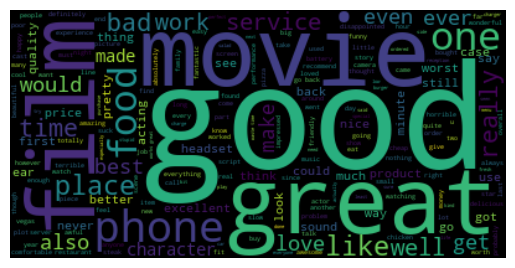

In [38]:
stopwords.update(["br", "href"])

textt = " ".join(donereview for donereview in sentence)

wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png')
plt.show()

In [39]:
finaldf

,review,sentiments,Source,Length,Words,emoji,emote,word_count,donereview
0,So there is no way for me to plug it in here i...,0,amazon,82,21,False,False,21,way plug us unless go converter
1,"Good case, Excellent value.",1,amazon,27,4,False,False,4,good case excellent value
2,Great for the jawbone.,1,amazon,22,4,False,False,4,great jawbone
3,Tied to charger for conversations lasting more...,0,amazon,79,11,False,False,11,tied charger conversations lasting minutes maj...
4,The mic is great.,1,amazon,17,4,False,False,4,mic great
...,...,...,...,...,...,...,...,...,...
2743,I just got bored watching Jessice Lange take h...,0,imdb,63,11,False,False,11,got bored watching jessice lange take clothes
2744,"Unfortunately, any virtue in this film's produ...",0,imdb,92,14,False,False,14,unfortunately virtue film production work lost...
2745,"In a word, it is embarrassing.",0,imdb,32,6,False,False,6,word embarrassing
2746,Exceptionally bad!,0,imdb,20,2,False,False,2,exceptionally bad


In [40]:
#Vocab Size Test 1

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(finaldf['donereview'])
print("Vocab size:", len(tokenizer.word_index)+1)
commentary = finaldf['donereview']

keras_token =Tokenizer(filters='\t\n}~!#*=&><:;+.{/,(?$^_-"%@[\\]', oov_token ='[UNK]', lower = True)

keras_token.fit_on_texts(commentary)

word_count = keras_token.word_counts
word_index = keras_token.word_index

print("Size of our vocabulary in our dataset:", len(word_count)+1)
list(word_count.items())[42:47]

Vocab size: 4956
Size of our vocabulary in our dataset: 4956


[('time', 112),
 ('sound', 50),
 ('quality', 66),
 ('impressed', 19),
 ('going', 34)]

In [42]:
#Vocab Test 2

In [43]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the cleaned reviews
X = vectorizer.fit_transform(finaldf['donereview'])

# Get the vocabulary size
vocab_size = len(vectorizer.get_feature_names_out())

# Print the vocabulary size
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 4941


In [44]:
# Split the data set
split = round(len(finaldf) * 0.8)
trrvw = finaldf['donereview'][:split]
trlbl = finaldf['sentiments'][:split]
tsrvw = finaldf['donereview'][split:]
tslbl = finaldf['sentiments'][split:]
print('Shape of training set:', trrvw.shape[0])
print('Shape of test set:', tsrvw.shape[0])

Shape of training set: 2198
Shape of test set: 550


In [45]:
#Vocab Test 3

In [46]:
# Set up tokenization and padding
vocab_size = 2200
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = ''

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(trrvw)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 3803


In [47]:
finaldf

,review,sentiments,Source,Length,Words,emoji,emote,word_count,donereview
0,So there is no way for me to plug it in here i...,0,amazon,82,21,False,False,21,way plug us unless go converter
1,"Good case, Excellent value.",1,amazon,27,4,False,False,4,good case excellent value
2,Great for the jawbone.,1,amazon,22,4,False,False,4,great jawbone
3,Tied to charger for conversations lasting more...,0,amazon,79,11,False,False,11,tied charger conversations lasting minutes maj...
4,The mic is great.,1,amazon,17,4,False,False,4,mic great
...,...,...,...,...,...,...,...,...,...
2743,I just got bored watching Jessice Lange take h...,0,imdb,63,11,False,False,11,got bored watching jessice lange take clothes
2744,"Unfortunately, any virtue in this film's produ...",0,imdb,92,14,False,False,14,unfortunately virtue film production work lost...
2745,"In a word, it is embarrassing.",0,imdb,32,6,False,False,6,word embarrassing
2746,Exceptionally bad!,0,imdb,20,2,False,False,2,exceptionally bad


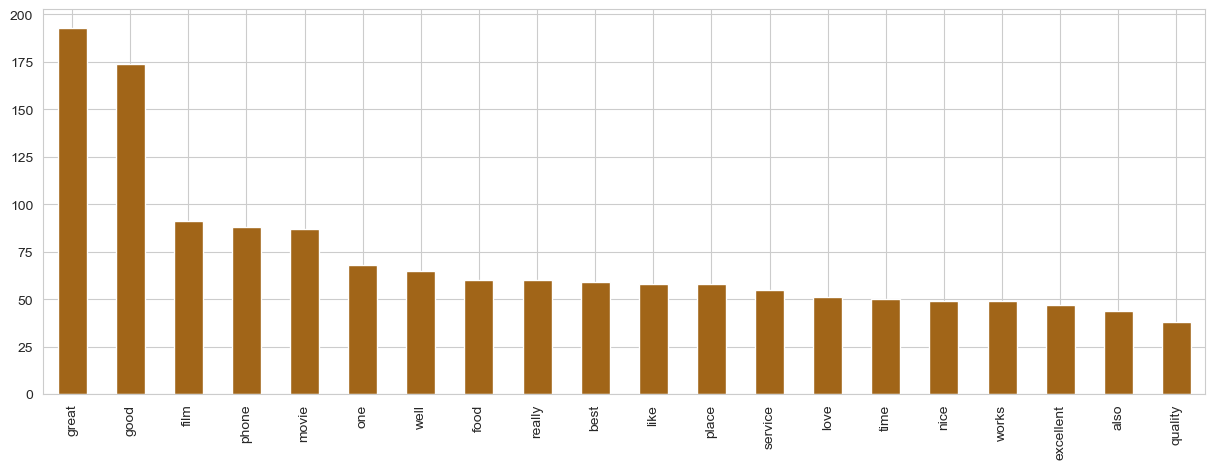

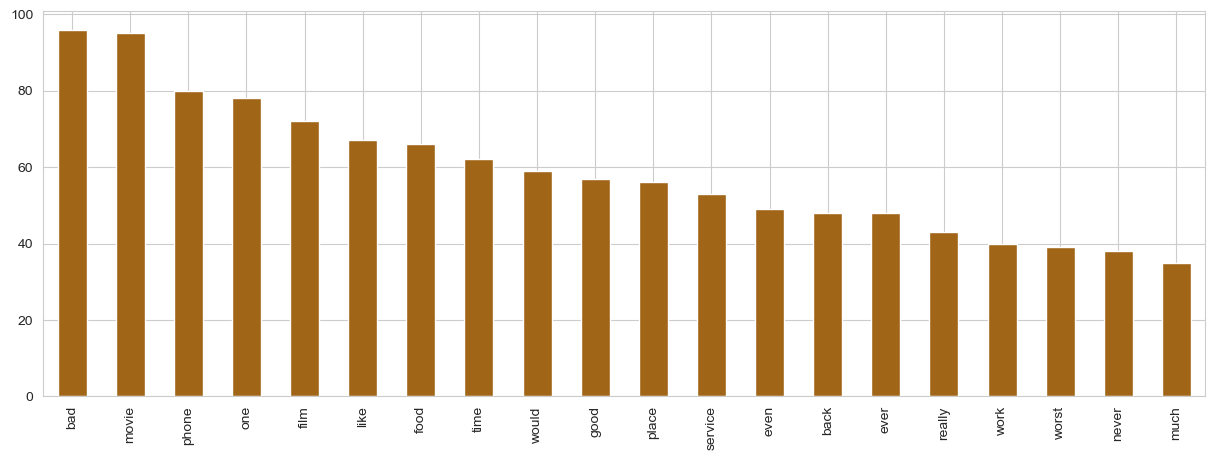

In [48]:

# Separate positive and negative reviews
positive_reviews = finaldf[finaldf['sentiments'] == 1]['donereview']
negative_reviews = finaldf[finaldf['sentiments'] == 0]['donereview']

# Visualization
split_df = [positive_reviews, negative_reviews]
for item in split_df:
    plt.figure(figsize=(15, 5))
    pd.Series(' '.join([i for i in item]).split()).value_counts().head(20).plot(kind='bar')
    plt.show()


In [49]:
# Check vocabulary size and proposed word embedding length
r_length = finaldf.donereview.str.len()
r_length

0       31
1       25
2       13
3       57
4        9
        ..
2743    45
2744    65
2745    17
2746    17
2747    40
Name: donereview, Length: 2748, dtype: int64

In [50]:
# Check length of shortest review
print(f"The shortest review is {min(r_length)} words.")

# Check length of longest review
print(f"The longest review is {max(r_length)} words.")

# Check total length of all reviews
print(f"The total length of all reviews is {sum(r_length)} characters.")

The shortest review is 0 words.
The longest review is 4901 words.
The total length of all reviews is 120601 characters.


In [51]:
# Prepare padded sequences for training and testing
train_sequences = tokenizer.texts_to_sequences(trrvw)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
trlbl_final = np.array(trlbl)

test_sequences = tokenizer.texts_to_sequences(tsrvw)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
tslbl_final = np.array(tslbl)

In [52]:
print("Training sequences:\n", trrvw)

Training sequences:
 0                         way plug us unless go converter
1                               good case excellent value
2                                           great jawbone
3       tied charger conversations lasting minutes maj...
4                                               mic great
                              ...                        
2193                                  high adventure best
2194    think robert ryans best film portrayed someone...
2195                               humour get get day apt
2196    mother brother saw robert ryan portraying type...
2197        almost songs cover girl old fashioned tuneful
Name: donereview, Length: 2198, dtype: object


In [53]:
print(trrvw[0])

way plug us unless go converter


In [54]:
# Ensure consistency in the splitting logic
print(len(trrvw), len(trlbl))
print(len(tsrvw), len(tslbl))

2198 2198
550 550


In [55]:
# Display counts of sentiments
sentiments_count = finaldf.groupby('sentiments').count()
print(sentiments_count)

            review  Source  Length  Words  emoji  emote  word_count  \
sentiments                                                            
0             1362    1362    1362   1362   1362   1362        1362   
1             1386    1386    1386   1386   1386   1386        1386   

            donereview  
sentiments              
0                 1362  
1                 1386  


In [56]:
# Save prepared dataset to CSV
finaldf.to_csv("finaldfclean.csv", index=False)

In [57]:
# Prepare labels for training
trlbl_final = np.array(trlbl)
tslbl_final = np.array(tslbl)


# Create and compile TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           35200     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 35443 (138.45 KB)
Trainable params: 35443 (138.45 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [58]:
# Fit model for 15 epochs
epochs_num = 15
history_model1 = model.fit(padded_train_sequences, trlbl_final, epochs=epochs_num, validation_data=(padded_test_sequences, tslbl_final))

Epoch 1/15


69/69 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6937 - val_accuracy: 0.4564
Epoch 2/15
69/69 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4564
Epoch 3/15
69/69 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4564
Epoch 4/15
69/69 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5055 - val_loss: 0.6942 - val_accuracy: 0.4564
Epoch 5/15
69/69 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5055 - val_loss: 0.6932 - val_accuracy: 0.4564
Epoch 6/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5096 - val_loss: 0.6931 - val_accuracy: 0.4582
Epoch 7/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5837 - val_loss: 0.6820 - val_accuracy: 0.5400
Epoch 8/15
69/69 [

In [59]:
# Fit model for 15 epochs with early stopping
history_model2 = model.fit(padded_train_sequences, trlbl_final, epochs=epochs_num, validation_data=(padded_test_sequences, tslbl_final), callbacks=[EarlyStopping(monitor='val_loss')])

Epoch 1/15
69/69 [==============================] - 0s 5ms/step - loss: 0.2096 - accuracy: 0.9322 - val_loss: 0.5391 - val_accuracy: 0.7509
Epoch 2/15
69/69 [==============================] - 0s 4ms/step - loss: 0.1941 - accuracy: 0.9331 - val_loss: 0.5799 - val_accuracy: 0.7327


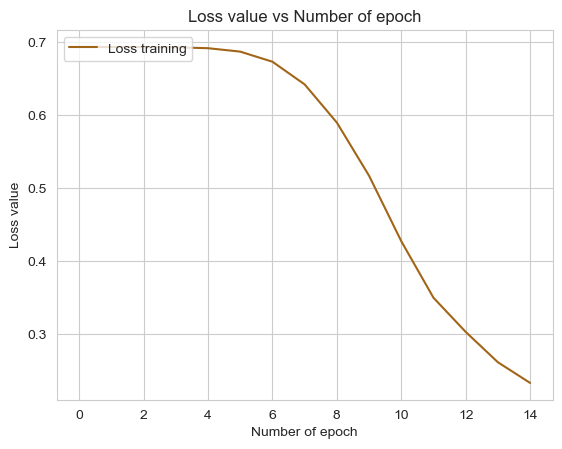

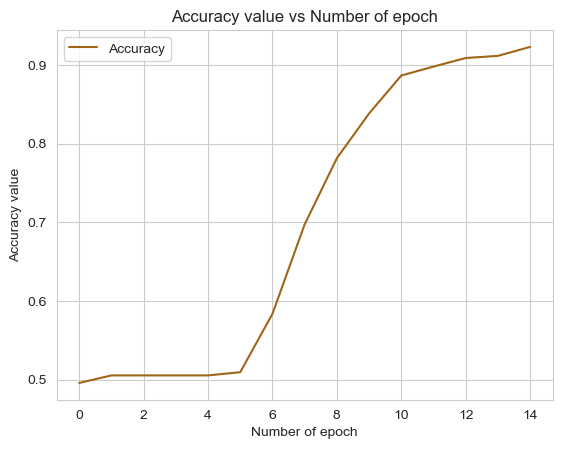

In [60]:
# Plot loss vs. epoch
plt.plot(history_model1.history['loss'], label='Loss training')
plt.title('Loss value vs Number of epoch')
plt.xlabel('Number of epoch')
plt.ylabel('Loss value')
plt.legend(loc="upper left")
plt.show()

# Plot accuracy vs. epoch
plt.plot(history_model1.history['accuracy'], label='Accuracy')
plt.title('Accuracy value vs Number of epoch')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy value')
plt.legend(loc="upper left")
plt.show()

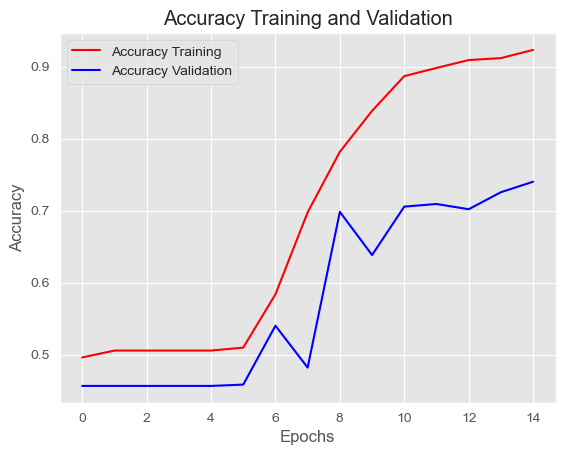

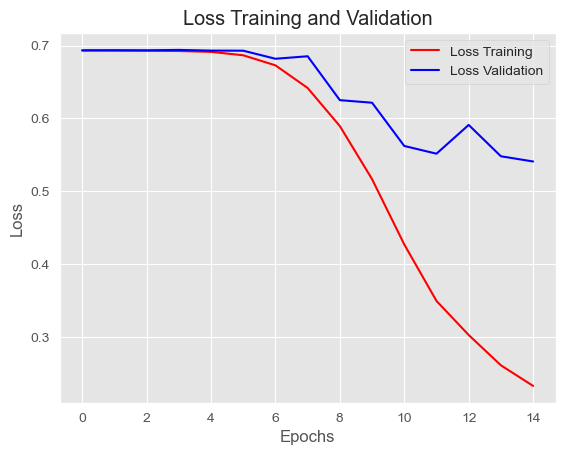

In [61]:

# Visualize model alongside loss function
plt.style.use('ggplot')

history = history_model1.history

plt.plot(history['accuracy'], 'r', label='Accuracy Training')
plt.plot(history['val_accuracy'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history['loss'], 'r', label='Loss Training')
plt.plot(history['val_loss'], 'b', label='Loss Validation')
plt.title('Loss Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [62]:
# Analyze the model
score = model.evaluate(padded_train_sequences, trlbl_final, verbose=0)[1] * 100
print(f'Accuracy: {score:.2f}%')



Accuracy: 93.68%


In [63]:
score = model.evaluate(padded_train_sequences, trlbl_final, verbose=0)
accuracy = score[1] * 100
loss = score[0]* 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Test accuracy: {accuracy:.2f}% / Test loss: {loss:.2f}%')


Accuracy: 93.68%
Test accuracy: 93.68% / Test loss: 17.92%


In [64]:
model.save('FinalMocdl.h5')